

**Installing  packages**


In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 1.3MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
!gdown https://drive.google.com/uc?id=1ZMiPKD6qDLa5_IYymF2gC1YuP2g453yV && unzip data.zip 

Downloading...
From: https://drive.google.com/uc?id=1ZMiPKD6qDLa5_IYymF2gC1YuP2g453yV
To: /content/data.zip
100% 1.73M/1.73M [00:00<00:00, 104MB/s]
Archive:  data.zip
  inflating: data/NotreDame1.jpg     
  inflating: data/NotreDame1_re.jpg  
  inflating: data/NotreDame2.jpg     
  inflating: data/NotreDame2_re.jpg  


In [0]:
!mkdir -p out/1 && mkdir -p out/2 && mkdir -p out/3 && mkdir -p out/4 && mkdir -p out/5 && mkdir -p out/6

##=============== **Answer to the question No: 01** ======================

### Process of Harris Corner Detection Algorithm
1. Color to grayscale
2. Spatial derivative calculation
3. Structure tensor setup
4. Harris response calculation
5. Non-maximum suppression

#### Step 1 : Color to grayscale

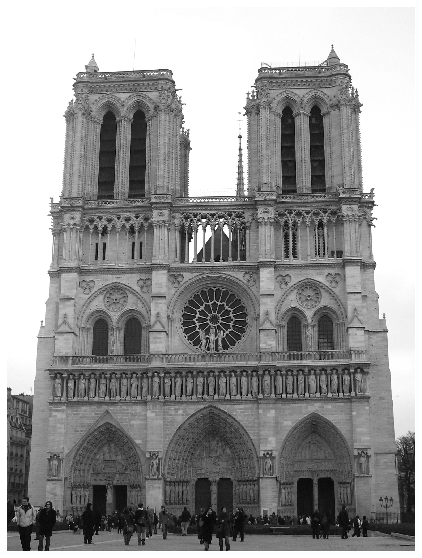

In [0]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

img = imread('data/NotreDame1.jpg')
imggray = rgb2gray(img)

plt.figure(figsize=(10,10))
plt.imshow(imggray, cmap="gray")
plt.axis("off")
plt.show()

#### Step 2 : Spatial derivative calculation

In [0]:
from scipy import signal as sig
import numpy as np

def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')
def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(imggray)
I_y = gradient_y(imggray)

#### Step 3 : Structure tensor setup

In [0]:
Ixx = I_x**2
Ixy = I_y*I_x
Iyy = I_y**2

#### Step 4: Harris response calculation

In [0]:
#Loop through image and find our corners
k = 0.05

height, width = imggray.shape
harris_response = []
window_size = 6
offset = window_size//2
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
        
        #Find determinant and trace, use to get corner response
        det = (Sxx * Syy) - (Sxy**2)
        trace = Sxx + Syy
        r = det - k*(trace**2)
        
        harris_response.append([x,y, r])

#### Step 5: Non-maximum suppression
1. Edge : r < 0
2. Corner : r > 0
3. Flat: r = 0

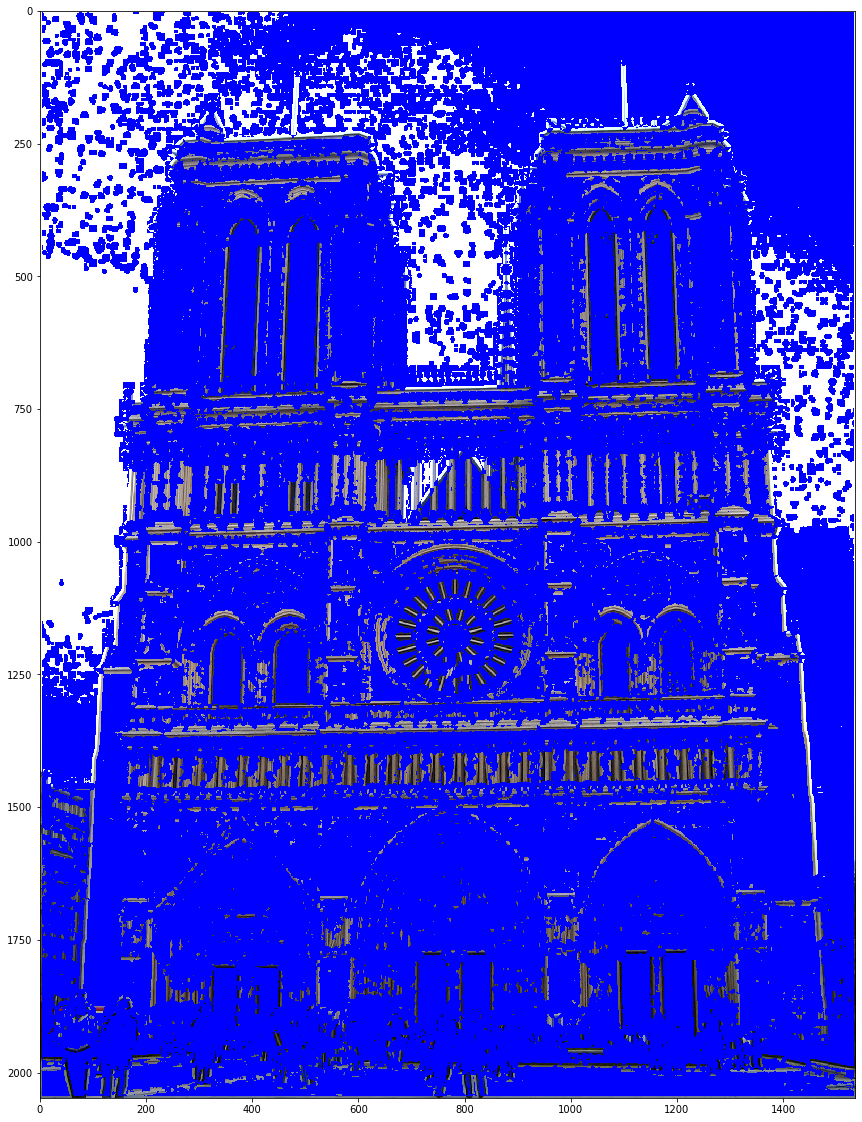

In [0]:
img_copy = np.copy(img)

for response in harris_response:
    x, y, r = response
    if r > 0:
        img_copy[y,x] = [0,0,255]

plt.figure(figsize=(20,20))        
plt.imshow(img_copy)
plt.show()

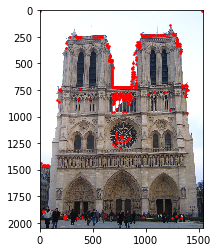

In [0]:
#Harris corner detection using skimage library
from skimage.feature import corner_harris, corner_peaks
# print corner_harris(ximage)
coords = corner_peaks(corner_harris(imggray))

fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.r', markersize=3)

##=============== **Answer to the question No: 02** ======================

Getting the features from the Harris Detector


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in true_divide


Number of features (left):  100
Number of features (right):  98
Finding the best matches between images using MOPS


Number of matches =  98
elapsed time: 20.67 s (20668.7093 ms)


Performing RANSAC
Number of pruned matches =  8


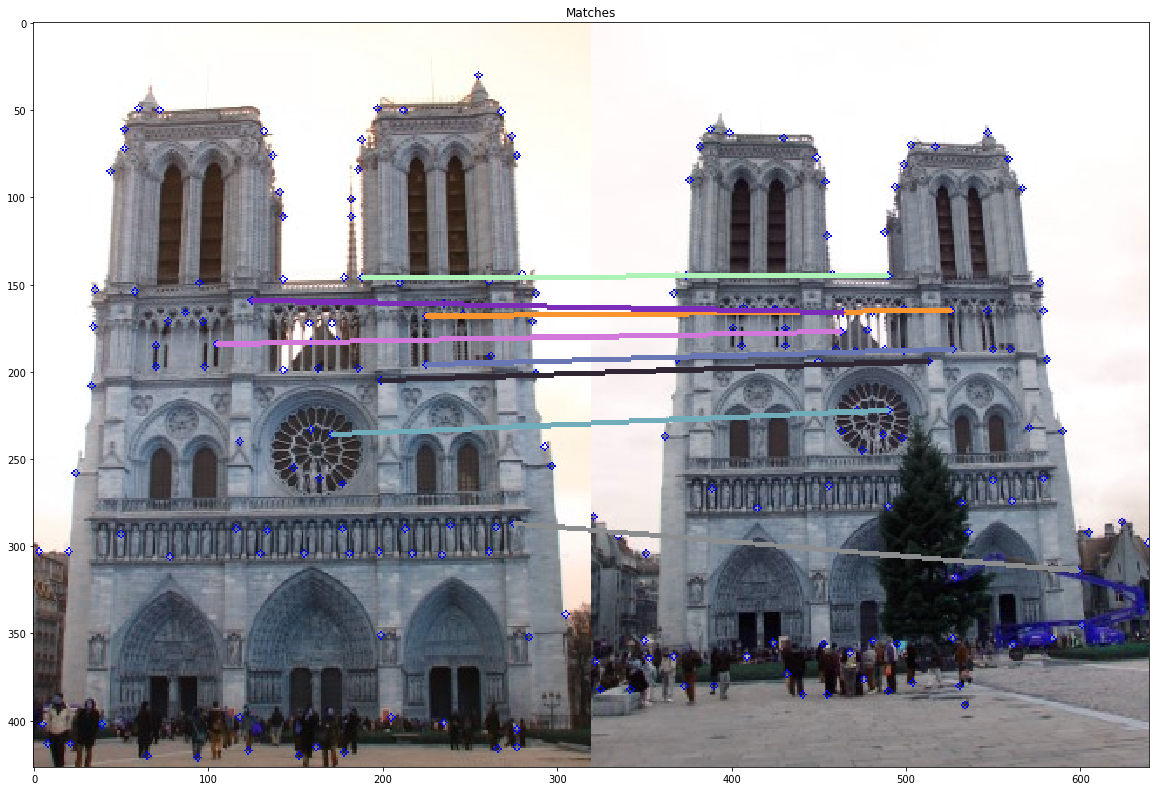

In [0]:
#!/usr/bin/env python3
import cv2
import math
import time
import pywt
import numpy as np
import argparse as ap
import matplotlib.pyplot as plt
from skimage.transform import warp, AffineTransform
from operator import itemgetter



def ransac(pts1, pts2, img_l, img_r, max_iters=1000, epsilon=1):
    best_matches = []
    # Number of samples
    N = 4

    for i in range(max_iters):
        # Get 4 random samples from features
        idx = np.random.randint(0, len(pts1) - 1, N)
        src = pts1[idx]
        dst = pts2[idx]

        # Calculate the homography matrix H
        H = cv2.getPerspectiveTransform(src, dst)
        Hp = cv2.perspectiveTransform(pts1[None], H)[0]

        # Find the inliers by computing the SSD(p',Hp) and saving inliers (feature pairs) that are SSD(p',Hp) < epsilon
        inliers = []
        for i in range(len(pts1)):
            ssd = np.sum(np.square(pts2[i] - Hp[i]))
            if ssd < epsilon:
                inliers.append([pts1[i], pts2[i]])

        # Keep the largest set of inliers and the corresponding homography matrix
        if len(inliers) > len(best_matches):
            best_matches = inliers

    return best_matches

# Plotting tool for convenience


def plot(plots):
    fig = plt.figure()
    N = len(plots)
    x = math.ceil(math.sqrt(N))
    y = math.ceil(math.sqrt(N))
    for i in range(N):
        fig.add_subplot(x, y, i+1).imshow(plots[i])
    plt.show()


def mops(img, truth, win_size, h, w, r):
    H, W = img.shape
    offset = win_size // 2

    
    # Rotate image s.t. gradient angle of feature is origin
    M = cv2.getRotationMatrix2D((w, h), -1*r, 1)
    img_rot = cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_NEAREST)

    # Get 40x40 window around feature
    win = img_rot[h-offset:h+offset, w-offset:w+offset]

    # Size (s,s) of each sample region
    s = win_size // 8
    # Prefiltering (N,N) -> (N//s, N//s)
    i = 0
    rows = []
    while i < win_size:
        j = 0
        cols = []
        while j < win_size:
            # Sample (s,s) region from window
            sample = win[i:i+s, j:j+s]
            # Downsample (s,s) region to a single value
            sample = np.sum(sample) / (s*s)
            cols.append(sample)
            j += s
        rows.append(cols)
        i += s

    feature = np.array(rows)
    # Normalize
    feature = (feature - np.mean(feature)) / np.std(feature)
    # Haar wave transform
    coeffs = pywt.dwt2(feature, 'haar')
    feature = pywt.idwt2(coeffs, 'haar')
    #plot([img, img_rot, truth, win, feature])
    return feature


def get_matches(ft1, ft2, left_match, right_match, img_left, img_right, max_matches, win_size):
    potential_matches = []
    offset = win_size // 2

    # Feature descriptor with brute-force matching
    for h1, w1, r1 in ft1:

        # Copy image as to not modify it by reference
        img_left_tmp = np.copy(img_left)

        # Copy coordinates incase changed by border
        h1_tmp = h1
        w1_tmp = w1

        # Get 40x40 window around feature
        win_left = img_left[h1-offset:h1+offset, w1-offset:w1+offset]

        # Handle border points
        if win_left.shape != (win_size, win_size):
            diff_h, diff_w = np.subtract(win_left.shape, (win_size, win_size))
            p_h = abs(diff_h // 2)
            p_w = abs(diff_w // 2)
            img_left_tmp = cv2.copyMakeBorder(
                img_left_tmp, p_h, p_h, p_w, p_w, cv2.BORDER_REFLECT)
            h1 += p_h
            w1 += p_w
            win_left = img_left_tmp[h1-offset:h1+offset, w1-offset:w1+offset]

        # Run multiscale oriented patches descriptor
        feature_left = mops(img_left_tmp, win_left, win_size, h1, w1, r1)

        lowest_dist = math.inf
        potential_match = ()
        for h2, w2, r2 in ft2:

            # Copy image as to not modify it by reference
            img_right_tmp = np.copy(img_right)

            # Copy coordinates incase changed by border
            h2_tmp = h2
            w2_tmp = w2

            # Get 40x40 window around feature
            win_right = img_right[h2-offset:h2+offset, w2-offset:w2+offset]

            # Handle border points
            if win_right.shape != (win_size, win_size):
                diff_h, diff_w = np.subtract(
                    win_right.shape, (win_size, win_size))
                p_h = abs(diff_h // 2)
                p_w = abs(diff_w // 2)
                img_right_tmp = cv2.copyMakeBorder(
                    img_right_tmp, p_h, p_h, p_w, p_w, cv2.BORDER_REFLECT)
                h2 += p_h
                w2 += p_w
                win_right = img_right_tmp[h2 -
                                          offset:h2+offset, w2-offset:w2+offset]

            # Run multiscale oriented patches descriptor
            feature_right = mops(img_right_tmp, win_right,
                                 win_size, h2, w2, r2)

            # Check distance between features
            curr_dist = np.linalg.norm(feature_left - feature_right)
            if curr_dist < lowest_dist:
                lowest_dist = curr_dist
                potential_match = ([h1_tmp, w1_tmp, r1], [
                                   h2_tmp, w2_tmp, r2], curr_dist)

        potential_matches.append(potential_match)

    # Sort matches from smallest distance up
    matches = sorted(potential_matches, key=itemgetter(2))
    for match in matches:
        # Ensure no duplicates
        if match[0][0:2] not in left_match and match[1][0:2] not in right_match:
            # Add to matches
            left_match.append(match[0][0:2])
            right_match.append(match[1][0:2])
            # Remove from potential matches
            ft1.remove(tuple(match[0]))
            ft2.remove(tuple(match[1]))

    # Recursively keep going until every point has a match
    while(len(left_match) < max_matches and len(right_match) < max_matches):
        
        get_matches(ft1, ft2, left_match, right_match,
                    img_left, img_right, max_matches, win_size)

    return np.array(left_match, dtype=np.float32), np.array(right_match, dtype=np.float32)


def harris(img, sigma=1, threshold=0.01):
    height, width = img.shape
    shape = (height, width)
    # Calculate the dx,dy gradients of the image (np.gradient doesnt work)
    dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    # Get angle for rotation
    _, ang = cv2.cartToPolar(dx, dy, angleInDegrees=True)
    # Square the derivatives (A,B,C of H) and apply apply gaussian filters to each
    sigma = (sigma, sigma)
    Ixx = cv2.GaussianBlur(dx * dx, sigma, 0)
    Ixy = cv2.GaussianBlur(dx * dy, sigma, 0)
    Iyy = cv2.GaussianBlur(dy * dy, sigma, 0)

    H = np.array([[Ixx, Ixy], [Ixy, Iyy]])
    # Find the determinate
    num = (H[0, 0] * H[1, 1]) - (H[0, 1] * H[1, 0])
    # Find the trace
    denom = H[0, 0] + H[1, 1]
    # Find the response using harmonic mean of the eigenvalues (Brown et. al. variation)
    R = np.nan_to_num(num / denom)

    # Adaptive non-maximum suppression, keep the top 1% of values and remove non-maximum points in a 9x9 neighbourhood
    R_flat = R[:].flatten()
    # Get number of values in top threshold %
    N = int(len(R_flat) * threshold)
    # Get values in top threshold %
    top_k_percentile = np.partition(R_flat, -N)[-N:]
    # Find lowest value in top threshold %
    minimum = np.min(top_k_percentile)
    # Set all values less than this to 0
    R[R < minimum] = 0
    # Set non-maximum points in an SxS neighbourhood to 0
    s = 9
    for h in range(R.shape[0] - s):
        for w in range(R.shape[1] - s):
            maximum = np.max(R[h:h+s+1, w:w+s+1])
            for i in range(h, h+s+1):
                for j in range(w, w+s+1):
                    if R[i, j] != maximum:
                        R[i, j] = 0

    # Return harris corners in [H, W, R] format
    features = list(np.where(R > 0))
    features.append(ang[np.where(R > 0)])
    corners = zip(*features)
    return list(corners)


def draw_corners(corners, img, name):
    for h, w, r in corners:
        cv2.circle(img, (w, h), 2, (0, 0, 255))

    cv2.imwrite(name + '.png', img)


def read_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("`{}` not cannot be loaded".format(image_path))
    return img


def draw_matches(matches, img_left, img_right, verbose=False):
    # Determine the max height
    height = max(img_left.shape[0], img_right.shape[0])
    # Width is the two images side-by-side
    width = img_left.shape[1] + img_right.shape[1]

    img_out = np.zeros((height, width, 3), dtype=np.uint8)
    # Place the images in the empty image
    img_out[0:img_left.shape[0], 0:img_left.shape[1], :] = img_left
    img_out[0:img_right.shape[0], img_left.shape[1]:, :] = img_right

    # The right image coordinates are offset since the image is no longer at (0,0)
    ow = img_left.shape[1]

    # Draw a line between the matched pairs in green
    for p1, p2 in matches:
        p1o = (int(p1[1]), int(p1[0]))
        p2o = (int(p2[1] + ow), int(p2[0]))
        color = list(np.random.random(size=3) * 256)
        cv2.line(img_out, p1o, p2o, color, thickness=2)

    if verbose:
        print("Press enter to continue ... ")
        cv2.imshow("matches", img_out)
        cv2.waitKey(0)
   
    plt.figure(figsize=(20, 20))
    plt.imshow(img_out)
    plt.title("Matches")
    plt.show()
    cv2.imwrite("out/2/matches.png", img_out)


class Timer(object):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.secs = self.end - self.start
        self.mins = self.secs // 60
        self.msecs = self.secs * 1000  # millisecs
        if self.verbose:
            print('elapsed time: {:.2f} s ({:.4f} ms)'.format(
                self.secs, self.msecs))


def main():
    # Load the image
    img_left_clr = read_image("data/NotreDame1_re.jpg")

   
    img_right_clr = read_image("data/NotreDame2_re.jpg")

    # Convert to grayscale
    img_left = cv2.cvtColor(img_left_clr, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right_clr, cv2.COLOR_RGB2GRAY)

    print("Getting the features from the Harris Detector")
    ftL = harris(img_left, sigma=3, threshold=0.01)
    draw_corners(ftL, img_left_clr, 'corners_left')
    ftR = harris(img_right, sigma=3, threshold=0.01)
    draw_corners(ftR, img_right_clr, 'corners_right')

    print("Number of features (left): ", len(ftL))
    print("Number of features (right): ", len(ftR))
    print("Finding the best matches between images using MOPS")
    with Timer(verbose=True) as t:
        max_matches = min(len(ftL), len(ftR))
        ptsL, ptsR = get_matches(
            ftL, ftR, [], [], img_left, img_right, max_matches, win_size=50)
        
        print("\n")
        print("Number of matches = ", len(ptsL))
        assert len(ptsL) == len(ptsR)
    print("\n")
    print("Performing RANSAC")
    matches = ransac(ptsL, ptsR, img_left, img_right,
     
                    1000, 100)
    print("Number of pruned matches = ", len(matches))

    draw_matches(matches, img_left_clr, img_right_clr)


if __name__ == "__main__":
    
    main()


##=============== **Answer to the question No: 03** ======================

Estimation Threshold:  0.6
Image 1 Name: NotreDame1.jpg
Image 2 Name: NotreDame2.jpg
Image successfully read...
Image successfully read...
Finding Features...
Finding Features...
Found keypoints in NotreDame1.jpg: 1483
Found keypoints in NotreDame2.jpg: 1203
Matching Features...


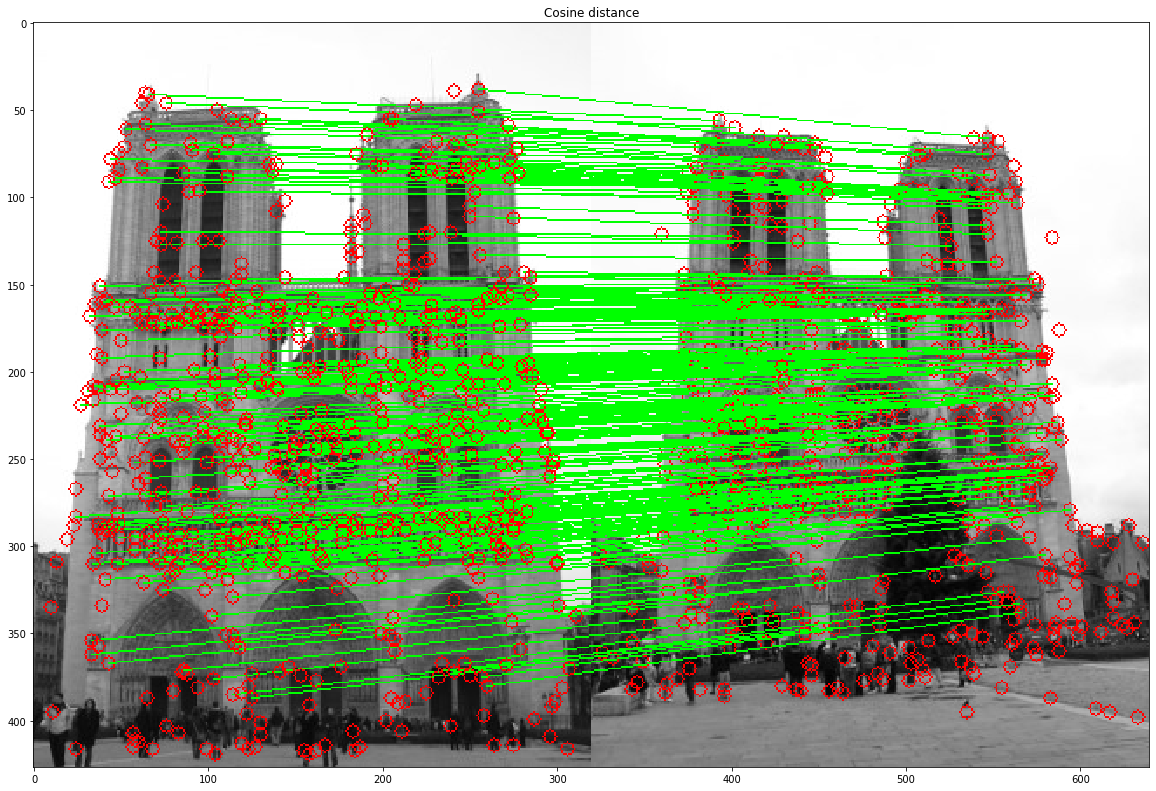

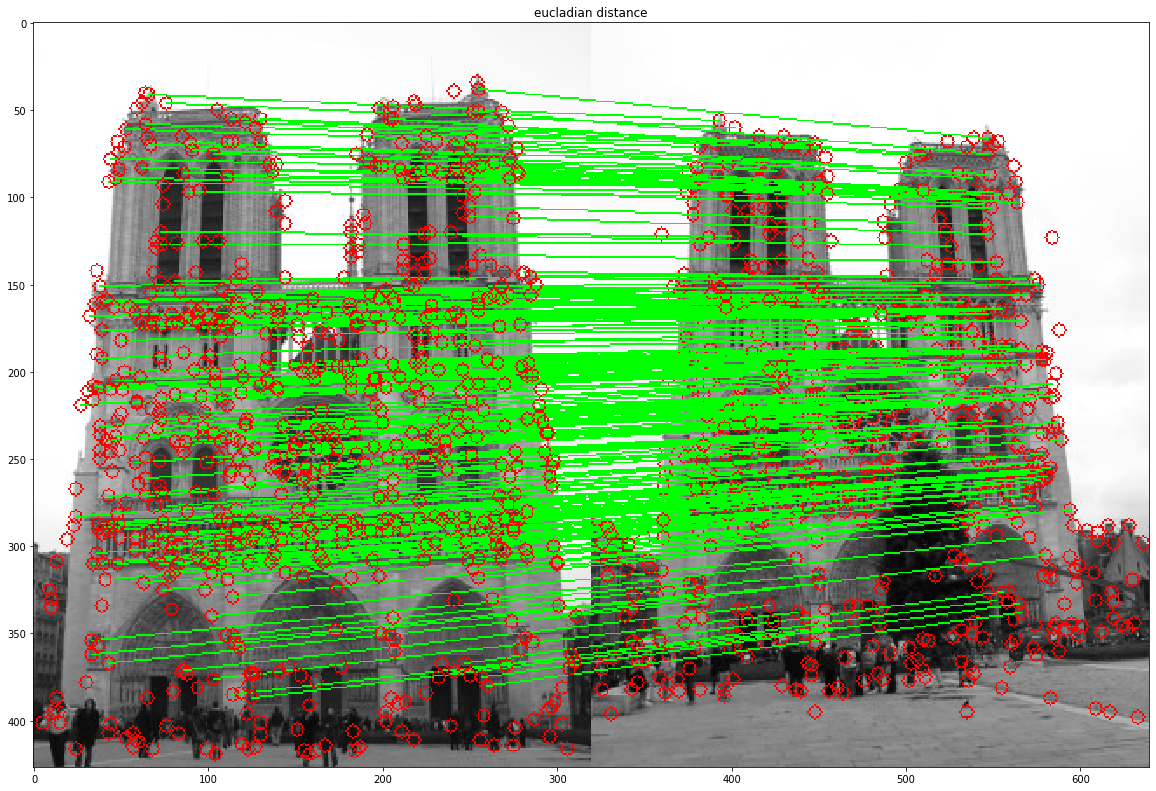

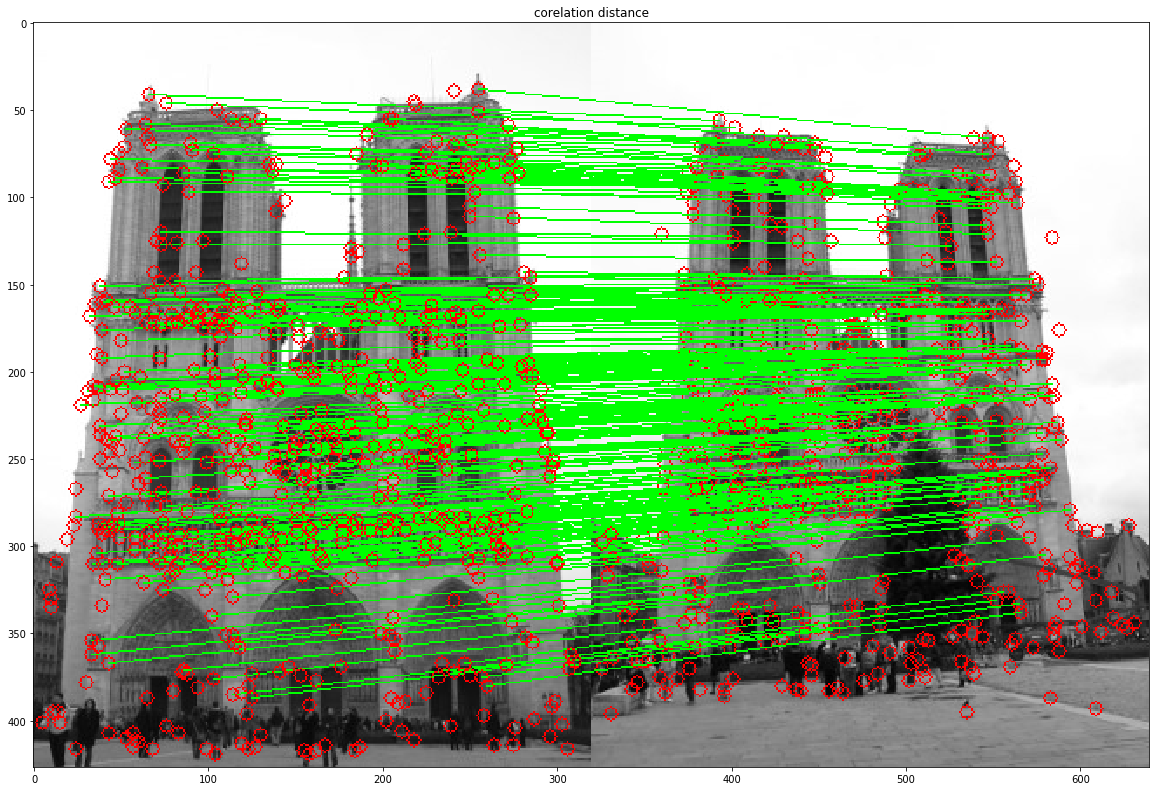

In [0]:

import cv2
import numpy as np
import getopt
import sys
import random
import matplotlib.pyplot as plt
from scipy import spatial
from scipy.spatial import distance

#
# Read in an image file, errors out if we can't find the file
#


def readImage(filename):
    img = cv2.imread(filename, 0)
    if img is None:
        print('Invalid image:' + filename)
        return None
    else:
        print('Image successfully read...')
        return img


def drawMatches(img1, kp1, img2, kp2, matches, inliers=None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros(
        (max([rows1, rows2]), cols1+cols2, 3), dtype='uint8')
    out2 = np.zeros(
        (max([rows1, rows2]), cols1+cols2, 3), dtype='uint8')
    out3 = np.zeros(
        (max([rows1, rows2]), cols1+cols2, 3), dtype='uint8')
    # Place the first image to the left
    out[:rows1, :cols1, :] = np.dstack([img1, img1, img1])
    out2[:rows1, :cols1, :] = np.dstack([img1, img1, img1])
    out3[:rows1, :cols1, :] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2, cols1:cols1+cols2, :] = np.dstack([img2, img2, img2])
    out2[:rows2, cols1:cols1+cols2, :] = np.dstack([img2, img2, img2])
    out3[:rows2, cols1:cols1+cols2, :] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:

                    inlier = True

        dataSetI = [x1, y1]
        dataSetII = [x2, y2]

        dstcosine = 1 - spatial.distance.cosine(dataSetI, dataSetII)
        dsteucla = distance.euclidean(dataSetI, dataSetII)
        dstcorelation = distance.correlation(dataSetI, dataSetII)

        if dstcosine > 0.90:
            # Draw a small circle at both co-ordinates
            cv2.circle(out, (int(x1), int(y1)), 4, (255, 0, 0), 1)
            cv2.circle(out, (int(x2)+cols1, int(y2)), 4, (255, 0, 0), 1)

            # Draw a line in between the two points, draw inliers if we have them
            if inliers is not None and inlier:
                cv2.line(out, (int(x1), int(y1)),
                         (int(x2)+cols1, int(y2)), (0, 255, 0), 1)

        if dsteucla > 0.70:
            # Draw a small circle at both co-ordinates
            cv2.circle(out2, (int(x1), int(y1)), 4, (255, 0, 0), 1)
            cv2.circle(out2, (int(x2)+cols1, int(y2)), 4, (255, 0, 0), 1)

            # Draw a line in between the two points, draw inliers if we have them
            if inliers is not None and inlier:
                cv2.line(out2, (int(x1), int(y1)),
                         (int(x2)+cols1, int(y2)), (0, 255, 0), 1)

        if dstcorelation <= 0:
            # Draw a small circle at both co-ordinates
            cv2.circle(out3, (int(x1), int(y1)), 4, (255, 0, 0), 1)
            cv2.circle(out3, (int(x2)+cols1, int(y2)), 4, (255, 0, 0), 1)

            # Draw a line in between the two points, draw inliers if we have them
            if inliers is not None and inlier:
                cv2.line(out3, (int(x1), int(y1)),
                         (int(x2)+cols1, int(y2)), (0, 255, 0), 1)

    return out, out2, out3

#
# Runs sift algorithm to find features
#


def findFeatures(img):
    print("Finding Features...")
    # sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return keypoints, descriptors

#
# Matches features given a list of keypoints, descriptors, and images
#


def matchFeatures(kp1, kp2, desc1, desc2, img1, img2):
    print("Matching Features...")
    matcher = cv2.BFMatcher(cv2.NORM_L2, True)
    matches = matcher.match(desc1, desc2)

    return matches


#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    # loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    # svd composition
    u, s, v = np.linalg.svd(matrixA)

    # reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    # matrixA = np.reshape(matrixA, (3, 3))

    # normalize and now we have h
    h = (1/h.item(8)) * h
    return h, matrixA


#
# Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    p1 = np.transpose(
        np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(
        np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


#
# Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    thresh = float(thresh)
    for i in range(1000):
        # find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        # call the homography function on those points
        h, matA = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        # print("Corr size: ", len(corr), " NumInliers: ",
        #       len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers, matA


#
# Main parses argument list and runs the functions
#
def main():

    estimation_thresh = 0.60
    print("Estimation Threshold: ", estimation_thresh)
    if estimation_thresh is None:
        estimation_thresh = 0.60

    img1name = str("NotreDame1.jpg")
    img2name = str("NotreDame2.jpg")
    print("Image 1 Name: " + img1name)
    print("Image 2 Name: " + img2name)

    img1 = readImage("data/NotreDame1_re.jpg")
    img2 = readImage("data/NotreDame2_re.jpg")

    # find features and keypoints
    correspondenceList = []
    if img1 is not None and img2 is not None:
        kp1, desc1 = findFeatures(img1)
        kp2, desc2 = findFeatures(img2)
        print("Found keypoints in " + img1name + ": " + str(len(kp1)))
        print("Found keypoints in " + img2name + ": " + str(len(kp2)))
        keypoints = [kp1, kp2]
        matches = matchFeatures(kp1, kp2, desc1, desc2, img1, img2)
        for match in matches:
            (x1, y1) = keypoints[0][match.queryIdx].pt
            (x2, y2) = keypoints[1][match.trainIdx].pt
            correspondenceList.append([x1, y1, x2, y2])

        corrs = np.matrix(correspondenceList)

        # run ransac algorithm
        finalH, inliers, matA = ransac(corrs, estimation_thresh)

        matchImg, matchImg2, matchImg3 = drawMatches(img1, kp1, img2, kp2,
                                                     matches, inliers)

        plt.figure(figsize=(20, 20))
        plt.imshow(matchImg)
        plt.title("Cosine distance")
        plt.show()
        print("\n")
        cv2.imwrite('out/3/FinalMatches{}.png'.format(
            str("Cosine_distance")), matchImg)

        plt.figure(figsize=(20, 20))
        plt.imshow(matchImg2)
        plt.title("eucladian distance")
        plt.show()
        print("\n")
        cv2.imwrite('out/3/FinalMatches{}.png'.format(
            str("eucladian_distance")), matchImg2)

        plt.figure(figsize=(20, 20))
        plt.imshow(matchImg3)
        plt.title("corelation distance")
        plt.show()
        print("\n")
        cv2.imwrite('out/3/FinalMatches{}.png'.format(
            str("corelation_distance")), matchImg3)


if __name__ == "__main__":
    main()


##=============== **Answer to the question No: 04** ======================

In [0]:

import cv2
import numpy as np
import getopt
import sys
import random

#
# Read in an image file, errors out if we can't find the file
#


def readImage(filename):
    img = cv2.imread(filename, 0)
    if img is None:
        print('Invalid image:' + filename)
        return None
    else:
        print('Image successfully read...')
        return img


def drawMatches(img1, kp1, img2, kp2, matches, inliers=None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1, rows2]), cols1+cols2, 3), dtype='uint8')

    # Place the first image to the left
    out[:rows1, :cols1, :] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2, cols1:cols1+cols2, :] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1), int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1, int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them
        if inliers is not None and inlier:
            cv2.line(out, (int(x1), int(y1)),
                     (int(x2)+cols1, int(y2)), (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1), int(y1)),
                     (int(x2)+cols1, int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1), int(y1)),
                     (int(x2)+cols1, int(y2)), (255, 0, 0), 1)

    return out

#
# Runs sift algorithm to find features
#


def findFeatures(img):
    print("Finding Features...")
    #sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    img = cv2.drawKeypoints(img, keypoints, outImage=None)
    cv2.imwrite('out/4/sift_keypoints.png', img)

    return keypoints, descriptors

#
# Matches features given a list of keypoints, descriptors, and images
#


def matchFeatures(kp1, kp2, desc1, desc2, img1, img2):
    print("Matching Features...")
    matcher = cv2.BFMatcher(cv2.NORM_L2, True)
    matches = matcher.match(desc1, desc2)
    matchImg = drawMatches(img1, kp1, img2, kp2, matches)
    cv2.imwrite('out/4/Matches.png', matchImg)
    return matches


#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    # loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    # svd composition
    u, s, v = np.linalg.svd(matrixA)

    # reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    # matrixA = np.reshape(matrixA, (3, 3))

    # normalize and now we have h
    h = (1/h.item(8)) * h
    return h, matrixA


#
# Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    p1 = np.transpose(
        np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(
        np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


#
# Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    thresh = float(thresh)
    for i in range(1000):
        # find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        # call the homography function on those points
        h, matA = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        # print(" size: ", len(corr), " Num Inliers: ",
        #       len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers, matA


#
# Main parses argument list and runs the functions
#
def main():

    estimation_thresh = 0.60
    print("Estimation Threshold: ", estimation_thresh)
    if estimation_thresh is None:
        estimation_thresh = 0.60

    img1name = str("NotreDame1_re.jpg")
    img2name = str("NotreDame2_re.jpg")
    print("Image 1 Name: " + img1name)
    print("Image 2 Name: " + img2name)

 

    img1 = readImage("data/NotreDame1_re.jpg")
    img2 = readImage("data/NotreDame2_re.jpg")

    # find features and keypoints
    correspondenceList = []
    if img1 is not None and img2 is not None:
        kp1, desc1 = findFeatures(img1)
        kp2, desc2 = findFeatures(img2)
        print("Found keypoints in " + img1name + ": " + str(len(kp1)))
        print("Found keypoints in " + img2name + ": " + str(len(kp2)))
        keypoints = [kp1, kp2]
        matches = matchFeatures(kp1, kp2, desc1, desc2, img1, img2)
        for match in matches:
            (x1, y1) = keypoints[0][match.queryIdx].pt
            (x2, y2) = keypoints[1][match.trainIdx].pt
            correspondenceList.append([x1, y1, x2, y2])

        corrs = np.matrix(correspondenceList)

        # run ransac algorithm
        finalH, inliers, matA = ransac(corrs, estimation_thresh)

        print("\n")
        print("================ Printing value of 'A' ======================")
        print("A = {} \n ".format(matA))
        print("================ Printing value of 'H' ======================")
        print("H = {} \n \n".format(finalH))
        print("================ Finaly A*H=0 format ======================")
        print("{} * {} = 0 \n".format(matA, finalH))
        
        print("Final inliers count: ", len(inliers))

        matchImg = drawMatches(img1, kp1, img2, kp2, matches, inliers)
        

        f = open('homography.txt', 'w')
        
        f.write("================ Printing value of 'A' ======================")
        f.write("A = {} \n ".format(matA))
        f.write("================ Printing value of 'H' ======================")
        f.write("H = {} \n \n".format(finalH))
        f.write("================ Finaly A*H=0 format ======================")
        f.write("{} * {} = 0 \n".format(matA, finalH))
        f.close()


if __name__ == "__main__":
    main()


Estimation Threshold:  0.6
Image 1 Name: NotreDame1_re.jpg
Image 2 Name: NotreDame2_re.jpg
Image successfully read...
Image successfully read...
Finding Features...
Finding Features...
Found keypoints in NotreDame1_re.jpg: 1483
Found keypoints in NotreDame2_re.jpg: 1203
Matching Features...


================ Printing value of 'A' ======================
A = [[-1.58183411e+02 -4.19664032e+02 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.82916736e+03  1.81179297e+04
   4.31724625e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.58183411e+02
  -4.19664032e+02 -1.00000000e+00  5.99633831e+04  1.59084161e+05
   3.79075043e+02]
 [-2.55369095e+02 -1.65780838e+02 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.01567852e+04  3.90526593e+04
   2.35567993e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.55369095e+02
  -1.65780838e+02 -1.00000000e+00  4.20739365e+04  2.73136123e+04
   1.64757355e+02]
 [-1.44772720e+02 -2.57539307e+02 -1

##=============== **Answer to the question No: 05** ======================

In [0]:

import cv2
import numpy as np
import getopt
import sys
import random

#
# Read in an image file, errors out if we can't find the file
#


def readImage(filename):
    img = cv2.imread(filename, 0)
    if img is None:
        print('Invalid image:' + filename)
        return None
    else:
        print('Image successfully read...')
        return img


def drawMatches(img1, kp1, img2, kp2, matches, inliers=None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1, rows2]), cols1+cols2, 3), dtype='uint8')

    # Place the first image to the left
    out[:rows1, :cols1, :] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2, cols1:cols1+cols2, :] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1), int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1, int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them
        if inliers is not None and inlier:
            cv2.line(out, (int(x1), int(y1)),
                     (int(x2)+cols1, int(y2)), (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1), int(y1)),
                     (int(x2)+cols1, int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1), int(y1)),
                     (int(x2)+cols1, int(y2)), (255, 0, 0), 1)

    return out

#
# Runs sift algorithm to find features
#


def findFeatures(img):
    print("Finding Features...")
    #sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    img = cv2.drawKeypoints(img, keypoints, outImage=None)
    cv2.imwrite('out/5/sift_keypoints.png', img)

    return keypoints, descriptors

#
# Matches features given a list of keypoints, descriptors, and images
#


def matchFeatures(kp1, kp2, desc1, desc2, img1, img2):
    print("Matching Features...")
    matcher = cv2.BFMatcher(cv2.NORM_L2, True)
    matches = matcher.match(desc1, desc2)
    matchImg = drawMatches(img1, kp1, img2, kp2, matches)
    cv2.imwrite('out/5/Matches.png', matchImg)
    return matches


#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    # loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    # svd composition
    u, s, v = np.linalg.svd(matrixA)

    # reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    # matrixA = np.reshape(matrixA, (3, 3))

    # normalize and now we have h
    h = (1/h.item(8)) * h
    return h, matrixA


#
# Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    p1 = np.transpose(
        np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(
        np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


#
# Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    thresh = float(thresh)
    for i in range(1000):
        # find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        # call the homography function on those points
        h, matA = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        # print(" size: ", len(corr), " Num of Inliers: ",
        #       len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers, matA


#
# Main parses argument list and runs the functions
#
def main():

    estimation_thresh = 0.60
    print("Estimation Threshold: ", estimation_thresh)
    if estimation_thresh is None:
        estimation_thresh = 0.60

    img1name = str("NotreDame1_re.jpg")
    img2name = str("NotreDame2_re.jpg")
    print("Image 1 Name: " + img1name)
    print("Image 2 Name: " + img2name)

   
    img1 = readImage("data/NotreDame1_re.jpg")
    img2 = readImage("data/NotreDame2_re.jpg")

    # find features and keypoints
    correspondenceList = []
    if img1 is not None and img2 is not None:
        kp1, desc1 = findFeatures(img1)
        kp2, desc2 = findFeatures(img2)
        print("Found keypoints in " + img1name + ": " + str(len(kp1)))
        print("Found keypoints in " + img2name + ": " + str(len(kp2)))
        keypoints = [kp1, kp2]
        matches = matchFeatures(kp1, kp2, desc1, desc2, img1, img2)
        for match in matches:
            (x1, y1) = keypoints[0][match.queryIdx].pt
            (x2, y2) = keypoints[1][match.trainIdx].pt
            correspondenceList.append([x1, y1, x2, y2])

        corrs = np.matrix(correspondenceList)

        # run ransac algorithm
        finalH, inliers, matA = ransac(corrs, estimation_thresh)

        print("=================== Final Homography matrix H: ===============")
        print("\n")
        print(finalH)
        

        matchImg = drawMatches(img1, kp1, img2, kp2, matches, inliers)
        

        f = open('Final_Homography.txt', 'w')
        
        f.write("\n")
        f.write("=================== Final Homography matrix H: =============== \n  {}".format(finalH))
        f.close()


if __name__ == "__main__":
    main()


Estimation Threshold:  0.6
Image 1 Name: NotreDame1_re.jpg
Image 2 Name: NotreDame2_re.jpg
Image successfully read...
Image successfully read...
Finding Features...
Finding Features...
Found keypoints in NotreDame1_re.jpg: 1483
Found keypoints in NotreDame2_re.jpg: 1203
Matching Features...
=================== Final Homography matrix H: ===============


[[ 8.29894448e-01  6.61082106e-03  1.98983636e+01]
 [ 2.84648960e-02  7.54343193e-01  2.63485875e+01]
 [ 1.14175095e-04 -2.44441926e-04  1.00000000e+00]]


##=============== **Answer to the question No: 06** ======================

In [0]:


import cv2
import numpy as np
from matplotlib import pyplot as plt
import math


# Importing the images
pic1 = cv2.imread("data/NotreDame1.jpg")
pic2 = cv2.imread("data/NotreDame2.jpg")


# Converting images to gray-scale
graypic1 = cv2.cvtColor(pic1, cv2.COLOR_BGR2GRAY)
graypic2 = cv2.cvtColor(pic2, cv2.COLOR_BGR2GRAY)

# Creating SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Finding keypoints and descriptors for Mountain images
keyp1, desc1 = sift.detectAndCompute(graypic1, None)
keyp2, desc2 = sift.detectAndCompute(graypic2, None)

# Drawing keypoints for Mountain images
keyImage1 = cv2.drawKeypoints(graypic1, keyp1, np.array([]), (0, 0, 255))
keyImage2 = cv2.drawKeypoints(graypic2, keyp2, np.array([]), (0, 0, 255))

plt.figure(figsize=(20, 20))
plt.title("SIfT detected first image")
plt.imshow(keyImage1)
plt.show()

print("\n")

plt.figure(figsize=(20, 20))
plt.title("SIfT detected second image")
plt.imshow(keyImage2)
plt.show()
print("\n")
cv2.imwrite('out/6/sift1.jpg', keyImage1)
cv2.imwrite('out/6/sift2.jpg', keyImage2)


# Brute-Force matching with SIFT descriptors
brutef = cv2.BFMatcher()

# Matching the keypoints with k-nearest neighbor (with k=2)
matches = brutef.knnMatch(desc1, desc2, k=2)

goodMatch = []
# Performing ratio test to find good matches
for m, n in matches:
    if m.distance < 0.75*n.distance:
        goodMatch.append(m)

# Drawing good matches
matchImage = cv2.drawMatches(
    pic1, keyp1, pic2, keyp2, goodMatch, np.array([]), (255, 0, 255), flags=2)

plt.figure(figsize=(20, 20))
plt.title("All matches point")
plt.imshow(matchImage)
plt.show()
print("\n")
cv2.imwrite('out/6/matches_knn.jpg', matchImage)


# Getting source and destination points
srce_pts = np.float32(
    [keyp1[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
dest_pts = np.float32(
    [keyp2[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)

# Finding Homography Matrix and mask
homographyMat, mask = cv2.findHomography(srce_pts, dest_pts, cv2.RANSAC, 5.0)



# Converting the mask to a list
matchesMask = mask.ravel().tolist()

h, w = pic1.shape[:2]
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

matchIndex = []
for i in range(len(matchesMask)):
    if (matchesMask[i]):
        matchIndex.append(i)

matchArray = []
for i in matchIndex:
    matchArray.append(goodMatch[i])

# Finding 10 random matches using inliers
randomMatch = np.random.choice(matchArray, 10, replace=False)

# Defining draw parameters
draw_params = dict(matchColor=(0, 0, 255),
                   singlePointColor=None,
                   flags=2)

# Drawing the match image for 10 random points
matchImage = cv2.drawMatches(
    pic1, keyp1, pic2, keyp2, randomMatch, None, **draw_params)

plt.figure(figsize=(20, 20))
plt.title("Feature matches")
plt.imshow(matchImage)
plt.show()
print("\n")
cv2.imwrite('out/6/matches.jpg', matchImage)

print("\n")
print("Applied homography matrix H=: \n {} \n".format(homographyMat))

h1, w1 = pic2.shape[:2]
h2, w2 = pic1.shape[:2]
pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
pts2_ = cv2.perspectiveTransform(pts2, homographyMat)
pts = np.concatenate((pts1, pts2_), axis=0)

# Finding the minimum and maximum coordinates
[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]

# Translating
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

# Warping the first image on the second image using Homography Matrix
result = cv2.warpPerspective(pic1, Ht.dot(
    homographyMat), (xmax-xmin, ymax-ymin))

#sresult[t[1]:h1+t[1], t[0]:w1+t[0]] = pic2

plt.figure(figsize=(20, 20))
plt.title("Homography applied image")
plt.imshow(result)
plt.show()
print("\n")
cv2.imwrite('out/6/Homography_applied_image.jpg', result)
